gate_fidelities: [1.    0.975 0.95  0.925 0.9   0.875 0.85  0.825 0.8   0.775 0.75  0.725
 0.7   0.675 0.65  0.625 0.6   0.575 0.55  0.525 0.5   0.475 0.45  0.425
 0.4   0.375 0.35  0.325 0.3   0.275 0.25  0.225 0.2   0.175 0.15  0.125
 0.1   0.075 0.05  0.025]
Running 100 trials for distance 1.0km (1/40)
Finished trials.
Running 100 trials for distance 0.975km (2/40)
Finished trials.
Running 100 trials for distance 0.95km (3/40)
Finished trials.
Running 100 trials for distance 0.925km (4/40)
Finished trials.
Running 100 trials for distance 0.9km (5/40)
Finished trials.
Running 100 trials for distance 0.875km (6/40)
Finished trials.
Running 100 trials for distance 0.85km (7/40)
Finished trials.
Running 100 trials for distance 0.825km (8/40)
Finished trials.
Running 100 trials for distance 0.8km (9/40)
Finished trials.
Running 100 trials for distance 0.775km (10/40)
Finished trials.
Running 100 trials for distance 0.75km (11/40)
Finished trials.
Running 100 trials for distance 0.7250000

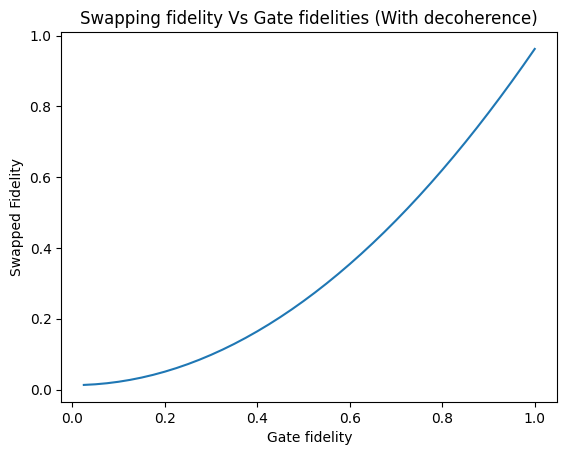

In [105]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

from SeQUeNCe.src.topology.router_net_topo import RouterNetTopo
from SeQUeNCe.src.app.request_app import RequestApp
import SeQUeNCe.src.utils.log as log


CONFIG_FILE = "config_files/swap_decoherence.json"

# meta params
NO_TRIALS = 100
OUTPUT_FILE = "results/variable_decoherence.csv"
LOGGING = False
LOG_OUTPUT = "results/var_decoherence_log.csv"
MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app", "optical_channel", "resource_manager"]

# simulation params
PREP_TIME = int(1e12)  # 1 second
COLLECT_TIME = int(5e10)  # 3.1, 10 seconds

# qc params
QC_FREQ = 1e11
total_distance = 20  # (unit: km)


gate_fidelities = np.linspace(1,0.025,int(0.975/0.025)+1) # This is the 0-0.975 case.
# gate_fidelities = [0.95]


# coherence_times = np.linspace(1, 100, 20)
# coherence_times = np.append(coherence_times, [-1])
# coherence_times = [0.030]
# coherence_times = [-1]
# coherence_times = np.array([10*4/3])
coherence_times = np.array([-1000])
# coherence_times = np.array([18, 55, -1000])
# coherence_times = np.array([20,40,60,80,100])
coherence_times = coherence_times * 1e-3 * 4/3

print("gate_fidelities:", gate_fidelities)


# application params
APP_NODE_NAME = "left"
OTHER_NODE_NAME = "right"
num_memo = 1

# storing data
data_dict = {"Distance": [],
             "Average Throughput": [],
             "Std. Throughput": [],
             "Average_TTT": [],
             "probs":[]}


fidelity_by_coherence = []
for coherence_time in coherence_times:
    tick = time.time()
    gate_swapped_fidelities_decoherence = []
    for i, gate_fidelity in enumerate(gate_fidelities):
        print(f"Running {NO_TRIALS} trials for distance {gate_fidelity}km ({i + 1}/{len(gate_fidelities)})")
        data_dict["Distance"].append(gate_fidelity)
        throughputs = np.zeros(NO_TRIALS)
        time_to_thousand = np.zeros(NO_TRIALS)
        probs = np.zeros(NO_TRIALS)
        temp_fidelities = []

        for trial_no in range(NO_TRIALS):
            # establish network
            net_topo = RouterNetTopo(CONFIG_FILE)

            # timeline setup
            tl = net_topo.get_timeline()
            tl.stop_time = PREP_TIME + COLLECT_TIME

            # Logging stuff
            if LOGGING:
                # set log
                if i == 3:
                    log.set_logger(__name__, tl, LOG_OUTPUT)
                    log.set_logger_level('WARN')
                    for module in MODULE_TO_LOG:
                        log.track_module(module)
                elif i == 4:
                    for module in MODULE_TO_LOG:
                        log.remove_module(module)

            # network configuration
            routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
            bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

            for j, node in enumerate(routers + bsm_nodes):
                node.set_seed(j + (trial_no * 3))

            # set gate fidelities
            for router in routers:
                router.meas_fid = gate_fidelity
                router.gate_fid = 0.95
                    
            # establish app on left node
            start_node = None
            for node in routers:
                if node.name == APP_NODE_NAME:
                    start_node = node
                    break
            if not start_node:
                raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
            end_node = None
            for node in routers:
                for memory in node.memory_array.memories:
                    memory.coherence_time = coherence_time
                    memory.decoherence_rate = 1/memory.coherence_time 
                if node.name == OTHER_NODE_NAME:
                    end_node = node
                    break
            if not start_node:
                raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

            app_start = RequestApp(start_node)
            app_end = RequestApp(end_node)

            tl.init()
            app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1)
            tl.run()

            temp_fidelities.append(routers[0].new_fidelity)
        gate_swapped_fidelities_decoherence.append(np.mean(temp_fidelities))
        print("Finished trials.")
    fidelity_by_coherence.append(gate_swapped_fidelities_decoherence)

print(gate_swapped_fidelities_decoherence)
plt.title("Swapping fidelity Vs Gate fidelities (With decoherence)")
plt.xlabel("Gate fidelity")
plt.ylabel("Swapped Fidelity")
plt.plot(gate_fidelities, gate_swapped_fidelities_decoherence)


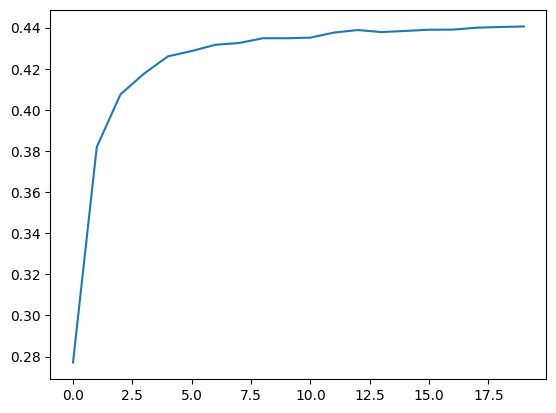

In [65]:
plt.plot(fidelity_by_coherence)

In [3]:
# DF = pd.DataFrame(fidelity_by_coherence) 
  
# # save the dataframe as a csv file 
# DF.to_csv("SeQUeNCe_bsm_005.csv")

df: [0.88064296 0.86487688 0.84911081 0.83334474 0.81757866 0.80181259
 0.78604651 0.77028044 0.75451437 0.73874829 0.72298222 0.70721614
 0.69145007 0.675684   0.65991792 0.64415185 0.62838577 0.6126197
 0.59685363 0.58108755 0.56532148 0.54955541 0.53378933 0.51802326
 0.50225718 0.48649111 0.47072504 0.45495896 0.43919289 0.42342681
 0.40766074 0.39189467 0.37612859 0.36036252 0.34459644 0.32883037
 0.3130643  0.29729822 0.28153215 0.26576607]
generartion fid: 1.0
decohered fid: 0.9563234001881865
swapped fid: 0.9151903275378681
final fid: 0.9020186765491044
theoretical: [0.90201868 0.88571821 0.86941774 0.85311728 0.83681681 0.82051634
 0.80421588 0.78791541 0.77161494 0.75531447 0.73901401 0.72271354
 0.70641307 0.69011261 0.67381214 0.65751167 0.64121121 0.62491074
 0.60861027 0.59230981 0.57600934 0.55970887 0.5434084  0.52710794
 0.51080747 0.494507   0.47820654 0.46190607 0.4456056  0.42930514
 0.41300467 0.3967042  0.38040374 0.36410327 0.3478028  0.33150233
 0.31520187 0.298

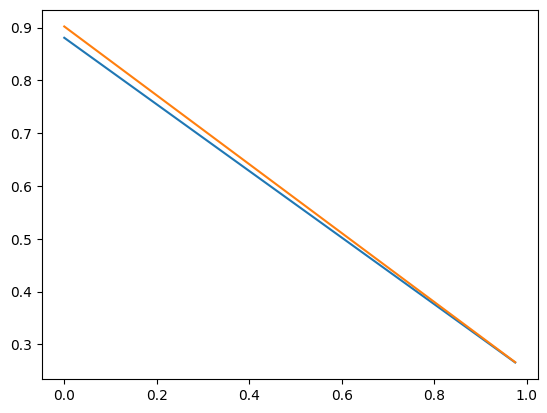

In [7]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

csvfile = open('SeQUeNCe_deterministic_EG.csv','r') 

decohere = lambda data,coherence_time,t: data*np.exp(-2*t/coherence_time) + (1-np.exp(-2*t/coherence_time))/4
swap_fidelity_perfect_meas = lambda p,f1,f2: ((1-p)/4) + p*(f1*f2 + (1-f1)*(1-f2)/3)

idx = 0
coherence_times = np.array([10,20,30,40,50,60,70,80,90,100])
coherence_times = coherence_times * 1e-3 

coherence_time = coherence_times[idx]

sequence_fidelities = np.array(pd.read_csv(csvfile))[idx][1:]

print("df:", sequence_fidelities)
# sequence_fidelities = list(df["w/o decoherence"])
# quisp_domain = list(df["Error Probability"])
# quisp_domain = [16/15*i for i in quisp_domain]

gate_fidelities = np.linspace(1,0.025,int(0.975/0.025)+1)
gate_errors = [1-i for i in gate_fidelities]

# theoretical_data = 0.25+3*gate_fidelities/4
generation_fidelity = np.ones(len(gate_errors))
print("generartion fid:", generation_fidelity[0])
decohered_fidelity = decohere(generation_fidelity, coherence_time, 3e-4)
print("decohered fid:", decohered_fidelity[0])
theoretical_data = swap_fidelity_perfect_meas(gate_fidelities, decohered_fidelity, decohered_fidelity)
print("swapped fid:", theoretical_data[0])
theoretical_data = decohere(theoretical_data, coherence_time, 1e-4)
print("final fid:", theoretical_data[0])

# t = 3e-4
# theoretical_data = decohere(theoretical_data, coherence_time, 3e-4)
# theoretical_data = decohere(theoretical_data, coherence_time, 3e-4)
# theoretical_data = decohere(theoretical_data, coherence_time, 1e-4)
# theoretical_data = decohere(theoretical_data, coherence_time, 1e-4)

print("theoretical:", theoretical_data)

plt.plot(gate_errors, sequence_fidelities)
plt.plot(gate_errors, theoretical_data)

# plt.title("Swapping fidelity vs gate fidelity (BSM:0.05)")
# plt.xlabel("Gate errors")
# plt.ylabel("Swapped Fidelity")
# for i in range(len(fidelity_by_coherence)):
#     plt.plot(gate_errors, fidelity_by_coherence[i], label = f"SeQUeNCe {int(coherence_times[i]*1e3)}ms")
# # plt.plot(quisp_domain, Quisp_fidelities, 'x', label = "Quisp no decoherence",)
# plt.legend()
# length = len(fidelity_by_coherence[0])

fidelity_by_coherence: [[0.9625000000000005, 0.9155937499999999, 0.869875, 0.8253437500000002, 0.7819999999999999, 0.7398437500000002, 0.698875, 0.6590937499999998, 0.6204999999999999, 0.58309375, 0.546875, 0.5118437500000002, 0.4779999999999999, 0.44534375000000004, 0.41387499999999994, 0.38359375000000023, 0.35450000000000026, 0.3265937499999999, 0.29987500000000006, 0.27434374999999994, 0.25, 0.22684375000000007, 0.2048750000000001, 0.18409374999999997, 0.16450000000000006, 0.14609375, 0.1288750000000001, 0.11284375000000005, 0.09800000000000007, 0.08434375000000005, 0.07187500000000006, 0.06059375000000003, 0.050500000000000045, 0.04159375000000003, 0.03387500000000001, 0.027343750000000035, 0.022000000000000033, 0.017843750000000016, 0.014875000000000017, 0.013093750000000008]]


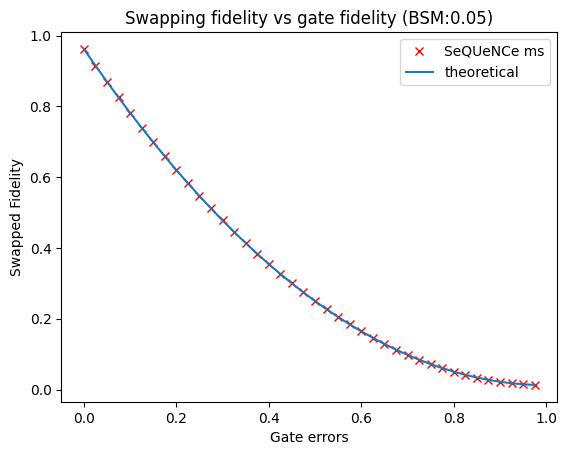

In [106]:
decohere = lambda data,coherence_time,t: data*np.exp(-2*t/coherence_time) + (1-np.exp(-2*t/coherence_time))/4
swap_fidelity_perfect_meas = lambda p,f1,f2: ((1-p)/4) + p*(f1*f2 + (1-f1)*(1-f2)/3)
swap_fidelity = lambda p,n,f1,f2: ((1-p)/4) + p*(n**2)*(f1*f2 + (1-f1)*(1-f2)/3)+(1-n**2)*((f1*(1-f2)/3) + (f2*(1-f1)/3) + 2*(1-f1)*(1-f2)/9)


gate_fidelities = np.linspace(1,0.025,int(0.975/0.025)+1)
gate_errors = [1-i for i in gate_fidelities]
# coherence_times = np.linspace(1, 100, 20)
# coherence_times = coherence_times * 1e-3

generation_fidelity = np.ones(len(gate_fidelities))
# decohered_fidelity = decohere(generation_fidelity, coherence_times, 3e-4)
theoretical_data = swap_fidelity(0.95, gate_fidelities, generation_fidelity, generation_fidelity)
# theoretical_data = decohere(theoretical_data, coherence_times, 1e-4)
print("fidelity_by_coherence:", fidelity_by_coherence)
# gate_errors = [1-i for i in gate_fidelities]


plt.title("Swapping fidelity vs gate fidelity (BSM:0.05)")
plt.xlabel("Gate errors")
plt.ylabel("Swapped Fidelity")
# for i in range(len(fidelity_by_coherence)):
plt.plot(gate_errors, fidelity_by_coherence[0], 'rx', label = f"SeQUeNCe ms")
plt.plot(gate_errors, theoretical_data, label="theoretical")
# plt.plot(quisp_domain, Quisp_fidelities, 'x', label = "Quisp no decoherence",)
plt.legend()
# length = len(fidelity_by_coherence[0])
# plt.xticks(list(range(0,41,4)), [i/10 for i in list(range(10,-1, -1))])

# plt.figure()
# plt.plot(np.abs(fidelity_by_coherence[0]-np.array(df["Quisp_10ms_gate"])))

# fidelity_by_coherence[i]

In [108]:
DF = pd.DataFrame(theoretical_data) 
# DF
# save the dataframe as a csv file 
DF.to_csv("theoretical_swap_deterministic_meas_0_8.csv")

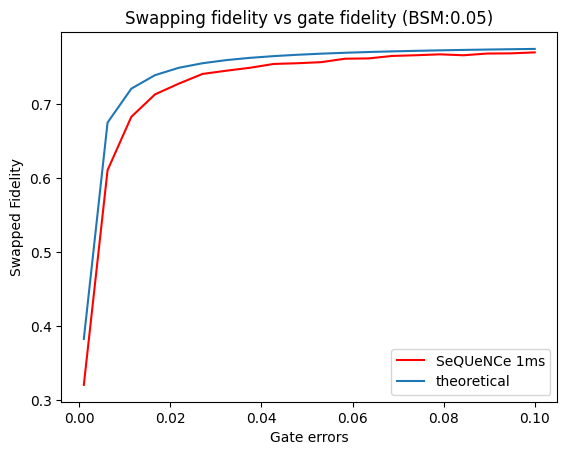

In [93]:
decohere = lambda data,coherence_time,t: data*np.exp(-2*t/coherence_time) + (1-np.exp(-2*t/coherence_time))/4
swap_fidelity_perfect_meas = lambda p,f1,f2: ((1-p)/4) + p*(f1*f2 + (1-f1)*(1-f2)/3)
swap_fidelity = lambda p,n,f1,f2: ((1-p)/4) + p*(n**2)*(f1*f2 + (1-f1)*(1-f2)/3)+(1-n**2)*((f1*(1-f2)/3) + (f2*(1-f1)/3) + 2*(1-f1)*(1-f2)/9)


# gate_fidelities = np.linspace(1,0.025,int(0.975/0.025)+1)
# gate_errors = [1-i for i in gate_fidelities]
coherence_times = np.linspace(1, 100, 20)
coherence_times = coherence_times * 1e-3

generation_fidelity = np.ones(len(coherence_times))
decohered_fidelity = decohere(generation_fidelity, coherence_times, 3e-4)
theoretical_data = swap_fidelity(0.95, 0.9, decohered_fidelity, decohered_fidelity)
theoretical_data = decohere(theoretical_data, coherence_times, 1e-4)

gate_errors = [1-i for i in gate_fidelities]


plt.title("Swapping fidelity vs gate fidelity (BSM:0.05)")
plt.xlabel("Gate errors")
plt.ylabel("Swapped Fidelity")
# for i in range(len(fidelity_by_coherence)):
plt.plot(coherence_times, fidelity_by_coherence, 'r', label = f"SeQUeNCe {int(coherence_times[i]*1e3)}ms")
plt.plot(coherence_times, theoretical_data, label="theoretical")
# plt.plot(quisp_domain, Quisp_fidelities, 'x', label = "Quisp no decoherence",)
plt.legend()
# length = len(fidelity_by_coherence[0])
# plt.xticks(list(range(0,41,4)), [i/10 for i in list(range(10,-1, -1))])

# plt.figure()
# plt.plot(np.abs(fidelity_by_coherence[0]-np.array(df["Quisp_10ms_gate"])))

# fidelity_by_coherence[i]

gate_fidelities: [1.    0.975 0.95  0.925 0.9   0.875 0.85  0.825 0.8   0.775 0.75  0.725
 0.7   0.675 0.65  0.625 0.6   0.575 0.55  0.525 0.5   0.475 0.45  0.425
 0.4   0.375 0.35  0.325 0.3   0.275 0.25  0.225 0.2   0.175 0.15  0.125
 0.1   0.075 0.05  0.025]
Running 200 trials for distance 1.0km (1/40)
Finished trials.
Running 200 trials for distance 0.975km (2/40)
Finished trials.
Running 200 trials for distance 0.95km (3/40)
Finished trials.
Running 200 trials for distance 0.925km (4/40)
Finished trials.
Running 200 trials for distance 0.9km (5/40)
Finished trials.
Running 200 trials for distance 0.875km (6/40)
Finished trials.
Running 200 trials for distance 0.85km (7/40)
Finished trials.
Running 200 trials for distance 0.825km (8/40)
Finished trials.
Running 200 trials for distance 0.8km (9/40)
Finished trials.
Running 200 trials for distance 0.775km (10/40)
Finished trials.
Running 200 trials for distance 0.75km (11/40)
Finished trials.
Running 200 trials for distance 0.7250000

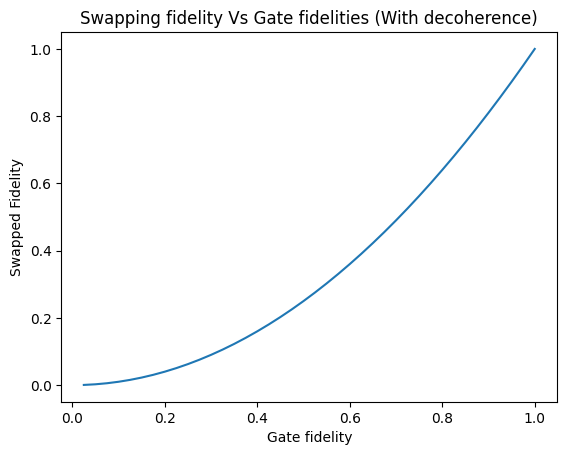

In [ ]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

from SeQUeNCe.src.topology.router_net_topo import RouterNetTopo
from SeQUeNCe.src.app.request_app import RequestApp
import SeQUeNCe.src.utils.log as log


CONFIG_FILE = "config_files/swap_decoherence.json"

# meta params
NO_TRIALS = 200
OUTPUT_FILE = "results/variable_decoherence.csv"
LOGGING = False
LOG_OUTPUT = "results/var_decoherence_log.csv"
MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app", "optical_channel", "resource_manager"]

# simulation params
PREP_TIME = int(1e12)  # 1 second
COLLECT_TIME = int(5e10)  # 3.1, 10 seconds

# qc params
QC_FREQ = 1e11
total_distance = 20  # (unit: km)


gate_fidelities = np.linspace(1,0.025,int(0.975/0.025)+1) # This is the 0-0.975 case.
# gate_fidelities = [1]


# coherence_times = np.linspace(20e-3, 40e-3, 5)
# coherence_times = np.append(coherence_times, [-1])
# coherence_times = [0.030]
# coherence_times = [-1]
# coherence_times = np.array([10*4/3])
coherence_times = np.array([18, 55, -1000])
# coherence_times = np.array([20,40,60,80,100])
coherence_times = coherence_times * 1e-3 

print("gate_fidelities:", gate_fidelities)


# application params
APP_NODE_NAME = "left"
OTHER_NODE_NAME = "right"
num_memo = 1

# storing data
data_dict = {"Distance": [],
             "Average Throughput": [],
             "Std. Throughput": [],
             "Average_TTT": [],
             "probs":[]}


fidelity_by_coherence = []
for coherence_time in coherence_times:
    tick = time.time()
    gate_swapped_fidelities_decoherence = []
    for i, gate_fidelity in enumerate(gate_fidelities):
        print(f"Running {NO_TRIALS} trials for distance {gate_fidelity}km ({i + 1}/{len(gate_fidelities)})")
        data_dict["Distance"].append(gate_fidelity)
        throughputs = np.zeros(NO_TRIALS)
        time_to_thousand = np.zeros(NO_TRIALS)
        probs = np.zeros(NO_TRIALS)
        temp_fidelities = []

        for trial_no in range(NO_TRIALS):
            # establish network
            net_topo = RouterNetTopo(CONFIG_FILE)

            # timeline setup
            tl = net_topo.get_timeline()
            tl.stop_time = PREP_TIME + COLLECT_TIME

            # Logging stuff
            if LOGGING:
                # set log
                if i == 3:
                    log.set_logger(__name__, tl, LOG_OUTPUT)
                    log.set_logger_level('WARN')
                    for module in MODULE_TO_LOG:
                        log.track_module(module)
                elif i == 4:
                    for module in MODULE_TO_LOG:
                        log.remove_module(module)

            # network configuration
            routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
            bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

            for j, node in enumerate(routers + bsm_nodes):
                node.set_seed(j + (trial_no * 3))

            # set gate fidelities
            for router in routers:
                router.meas_fid = gate_fidelity
                    
            # establish app on left node
            start_node = None
            for node in routers:
                if node.name == APP_NODE_NAME:
                    start_node = node
                    break
            if not start_node:
                raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
            end_node = None
            for node in routers:
                for memory in node.memory_array.memories:
                    memory.coherence_time = coherence_time
                    memory.decoherence_rate = 1/memory.coherence_time 
                if node.name == OTHER_NODE_NAME:
                    end_node = node
                    break
            if not start_node:
                raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

            app_start = RequestApp(start_node)
            app_end = RequestApp(end_node)

            tl.init()
            app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1)
            tl.run()

            temp_fidelities.append(routers[0].new_fidelity)
        gate_swapped_fidelities_decoherence.append(np.mean(temp_fidelities))
        print("Finished trials.")
    fidelity_by_coherence.append(gate_swapped_fidelities_decoherence)

print(gate_swapped_fidelities_decoherence)
plt.title("Swapping fidelity Vs Gate fidelities (With decoherence)")
plt.xlabel("Gate fidelity")
plt.ylabel("Swapped Fidelity")
plt.plot(gate_fidelities, gate_swapped_fidelities_decoherence)


[1.0,
 0.950625,
 0.9025,
 0.855625,
 0.8100000000000003,
 0.765625,
 0.7225,
 0.6806249999999998,
 0.6400000000000002,
 0.600625,
 0.5625,
 0.525625,
 0.49,
 0.45562500000000017,
 0.4225,
 0.390625,
 0.36000000000000015,
 0.33062499999999995,
 0.3025000000000001,
 0.27562499999999995,
 0.25,
 0.225625,
 0.20250000000000007,
 0.18062500000000004,
 0.16000000000000006,
 0.140625,
 0.12250000000000007,
 0.10562500000000007,
 0.09000000000000004,
 0.07562500000000003,
 0.06250000000000004,
 0.05062500000000004,
 0.04000000000000003,
 0.030625000000000017,
 0.02250000000000001,
 0.015625000000000028,
 0.01000000000000002,
 0.005625000000000011,
 0.002500000000000005,
 0.0006250000000000002]

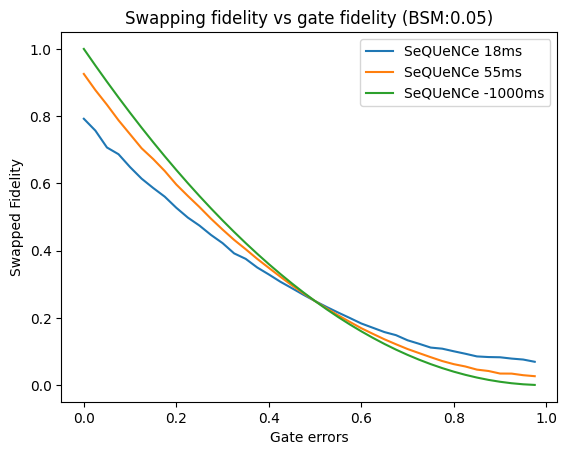

In [9]:
csvfile = open('plotting/Quisp_15_error.csv','r') 
df = pd.read_csv(csvfile)
Quisp_fidelities = list(df["w/o decoherence"])
quisp_domain = list(df["Error Probability"])
quisp_domain = [16/15*i for i in quisp_domain]

gate_errors = [1-i for i in gate_fidelities]


plt.title("Swapping fidelity vs gate fidelity (BSM:0.05)")
plt.xlabel("Gate errors")
plt.ylabel("Swapped Fidelity")
for i in range(len(fidelity_by_coherence)):
    plt.plot(gate_errors, fidelity_by_coherence[i], label = f"SeQUeNCe {int(coherence_times[i]*1e3)}ms")
# plt.plot(gate_errors, theoretical_data)
# plt.plot(quisp_domain, Quisp_fidelities, 'x', label = "Quisp no decoherence",)
plt.legend()
length = len(fidelity_by_coherence[0])
# plt.xticks(list(range(0,41,4)), [i/10 for i in list(range(10,-1, -1))])

# plt.figure()
# plt.plot(np.abs(fidelity_by_coherence[0]-np.array(df["Quisp_10ms_gate"])))

fidelity_by_coherence[i]

In [11]:
DF = pd.DataFrame(fidelity_by_coherence) 
DF
# save the dataframe as a csv file 
# DF.to_csv("SeQUeNCe_swap_probabilistic_final_meas.csv")

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.792297,0.757012,0.706847,0.686841,0.648486,0.614076,0.586383,0.560508,0.527478,0.498243,...,0.111715,0.108433,0.100683,0.093335,0.085417,0.083519,0.082866,0.078936,0.076124,0.069443
1,0.925620,0.877505,0.833985,0.787819,0.746184,0.704445,0.672413,0.636884,0.596695,0.562656,...,0.083169,0.071611,0.062379,0.055463,0.046129,0.042055,0.034458,0.034271,0.029555,0.026582
2,1.000000,0.950625,0.902500,0.855625,0.810000,0.765625,0.722500,0.680625,0.640000,0.600625,...,0.062500,0.050625,0.040000,0.030625,0.022500,0.015625,0.010000,0.005625,0.002500,0.000625


[0.8601515285944642,
 0.8315275366457313,
 0.82627212375845,
 0.8157405345958902,
 0.8001589238907968,
 0.7933211578835346,
 0.7647248700548462,
 0.7486832650640358,
 0.7380442988996063,
 0.7196366720541556,
 0.7114725478924232,
 0.6945965812541048,
 0.6812151099076091,
 0.6635826403402028,
 0.641325158007703,
 0.6297374535525745,
 0.615988281364221,
 0.5958080487061749,
 0.5854169712307071,
 0.5706533254687097,
 0.5579361448163865,
 0.5371694999974852,
 0.5247698360449445,
 0.5099671493740672,
 0.5005166739846836,
 0.4789564775408987,
 0.4663562654267,
 0.4457440532722376,
 0.433659441691626,
 0.4159011829795247,
 0.4020030327120249,
 0.388369173802412,
 0.3685364335431875,
 0.358335134733869,
 0.3435221011717334,
 0.3234074600998752,
 0.312129271698047,
 0.2959638324046217,
 0.2808439098667669,
 0.2649187771392409]

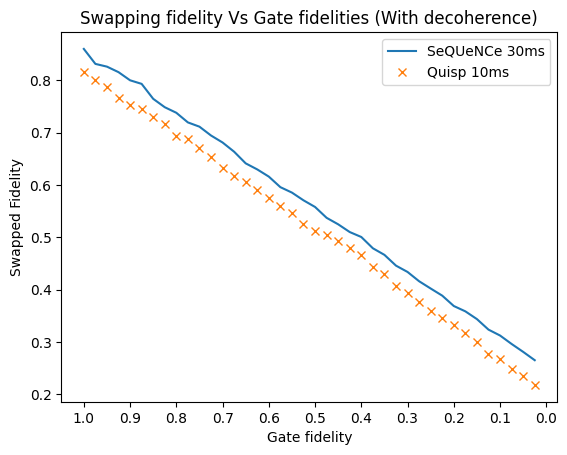

In [ ]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

from SeQUeNCe.src.topology.router_net_topo import RouterNetTopo
from SeQUeNCe.src.app.request_app import RequestApp
import SeQUeNCe.src.utils.log as log

gate_fidelities = np.linspace(1,0.025,int(0.975/0.025)+1)
coherence_times = [0.030]

csvfile = open('plotting/Quisp_15_error.csv','r') 
df = pd.read_csv(csvfile)
Quisp_fidelities = list(df["10ms"])

csvfile = open("SeQUeNCe_gate_swap.csv",'r') 
df = pd.read_csv(csvfile)

sequence_data = list(df["data"])
# print(sequence_data)


plt.title("Swapping fidelity Vs Gate fidelities (With decoherence)")
plt.xlabel("Gate fidelity")
plt.ylabel("Swapped Fidelity")
# for i in range(len(fidelity_by_coherence)):
plt.plot(sequence_data, label = f"SeQUeNCe {int(coherence_times[0]*1e3)}ms")
# Quisp_fidelities = [i+0.03 for i in Quisp_fidelities]
plt.plot(Quisp_fidelities, 'x', label = "Quisp 10ms",)
plt.legend()
length = len(sequence_data)
plt.xticks(list(range(0,41,4)), [i/10 for i in list(range(10,-1, -1))])

# plt.figure()
# plt.plot(np.abs(fidelity_by_coherence[0]-np.array(df["Quisp_10ms_gate"])))

sequence_data

In [ ]:
np.linspace(1,0.025,int(0.975/0.025)+1)

array([1.   , 0.975, 0.95 , 0.925, 0.9  , 0.875, 0.85 , 0.825, 0.8  ,
       0.775, 0.75 , 0.725, 0.7  , 0.675, 0.65 , 0.625, 0.6  , 0.575,
       0.55 , 0.525, 0.5  , 0.475, 0.45 , 0.425, 0.4  , 0.375, 0.35 ,
       0.325, 0.3  , 0.275, 0.25 , 0.225, 0.2  , 0.175, 0.15 , 0.125,
       0.1  , 0.075, 0.05 , 0.025])

In [ ]:
DF = pd.DataFrame(fidelity_by_coherence[i]) 
  
# save the dataframe as a csv file 
DF.to_csv("SeQUeNCe_gate_swap.csv")

### Varying Gate fidelities

gate_fidelities: [1.   0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35
 0.3  0.25 0.2  0.15 0.1  0.05 0.  ]
Running 1 trials for distance 1.0km (1/21)
memo size: 1
request received at right protocol name: EGA.right.MemoryArray[0] at time: 1000100000001
request received at center protocol name: EGA.center.MemoryArray[0] at time: 1000100000001
response received at center protocol name: EGA.center.MemoryArray[1] at time: 1000200000001
EG received message: at center, 1000200000001, GenerationMsgType.NEGOTIATE
response received at left protocol name: EGA.left.MemoryArray[0] at time: 1000200000001
EG received message: at left, 1000200000001, GenerationMsgType.NEGOTIATE
EG received message: at right, 1000300000001, GenerationMsgType.NEGOTIATE_ACK
EG received message: at center, 1000300000001, GenerationMsgType.NEGOTIATE_ACK
generation setting memory at time: 1000300012500 at right
generation setting memory at time: 1000300012500 at center
generation setting memory at time: 10

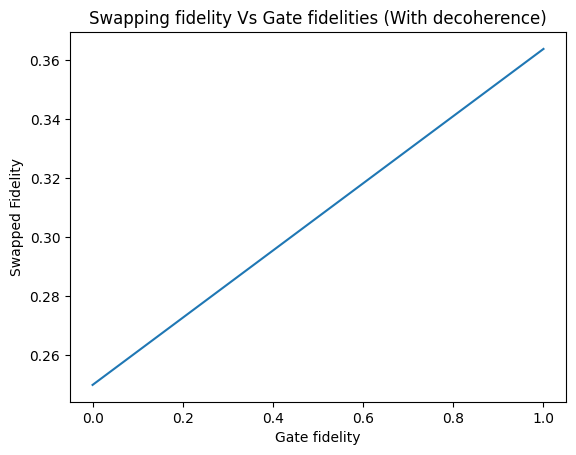

In [ ]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

from SeQUeNCe.src.topology.router_net_topo import RouterNetTopo
from SeQUeNCe.src.app.request_app import RequestApp
import SeQUeNCe.src.utils.log as log


CONFIG_FILE = "config_files/swap_decoherence.json"

# meta params
NO_TRIALS = 1
OUTPUT_FILE = "results/variable_decoherence.csv"
LOGGING = False
LOG_OUTPUT = "results/var_decoherence_log.csv"
MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app", "optical_channel", "resource_manager"]

# simulation params
PREP_TIME = int(1e12)  # 1 second
COLLECT_TIME = int(1e11)  # 3.1, 10 seconds

# qc params
QC_FREQ = 1e11
total_distance = 20  # (unit: km)

gate_fidelities = np.linspace(1,0,int(1/0.05)+1)
# gate_fidelities = [1]
print("gate_fidelities:", gate_fidelities)


# application params
APP_NODE_NAME = "left"
OTHER_NODE_NAME = "right"
num_memo = 1

# storing data
data_dict = {"Distance": [],
             "Average Throughput": [],
             "Std. Throughput": [],
             "Average_TTT": [],
             "probs":[]}


tick = time.time()
gate_swapped_fidelities_decoherence = []

for i, gate_fidelity in enumerate(gate_fidelities):
    print(f"Running {NO_TRIALS} trials for distance {gate_fidelity}km ({i + 1}/{len(gate_fidelities)})")
    data_dict["Distance"].append(gate_fidelity)
    throughputs = np.zeros(NO_TRIALS)
    time_to_thousand = np.zeros(NO_TRIALS)
    probs = np.zeros(NO_TRIALS)
    temp_fidelities = []

    for trial_no in range(NO_TRIALS):
        # establish network
        net_topo = RouterNetTopo(CONFIG_FILE)

        # timeline setup
        tl = net_topo.get_timeline()
        tl.stop_time = PREP_TIME + COLLECT_TIME

        # Logging stuff
        if LOGGING:
            # set log
            if i == 3:
                log.set_logger(__name__, tl, LOG_OUTPUT)
                log.set_logger_level('WARN')
                for module in MODULE_TO_LOG:
                    log.track_module(module)
            elif i == 4:
                for module in MODULE_TO_LOG:
                    log.remove_module(module)

        # network configuration
        routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
        bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

        for j, node in enumerate(routers + bsm_nodes):
            node.set_seed(j + (trial_no * 3))

        # set gate fidelities
        for router in routers:
            router.gate_fid = gate_fidelity
                
        # establish app on left node
        start_node = None
        for node in routers:
            if node.name == APP_NODE_NAME:
                start_node = node
                break
        if not start_node:
            raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
        end_node = None
        for node in routers:
            if node.name == OTHER_NODE_NAME:
                end_node = node
                break
        if not start_node:
            raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

        app_start = RequestApp(start_node)
        app_end = RequestApp(end_node)

        tl.init()
        app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 0.9)
        tl.run()

        temp_fidelities.append(routers[0].new_fidelity)
    gate_swapped_fidelities_decoherence.append(temp_fidelities)

    print("Finished trials.")

print(gate_swapped_fidelities_decoherence)
plt.title("Swapping fidelity Vs Gate fidelities (With decoherence)")
plt.xlabel("Gate fidelity")
plt.ylabel("Swapped Fidelity")
plt.plot(gate_fidelities, gate_swapped_fidelities_decoherence)


gate_fidelities: [1.   0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35
 0.3  0.25 0.2  0.15 0.1  0.05 0.  ]
Running 1 trials for distance 1.0km (1/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.95km (2/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.9km (3/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.85km (4/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.8km (5/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.75km (6/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.7km (7/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.6499999999999999km (8/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.6km (9/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.55km (10/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.5km (11/21)
memo size: 1
Finished trials.
Running 1 trials for distance 0.44999999999999996km

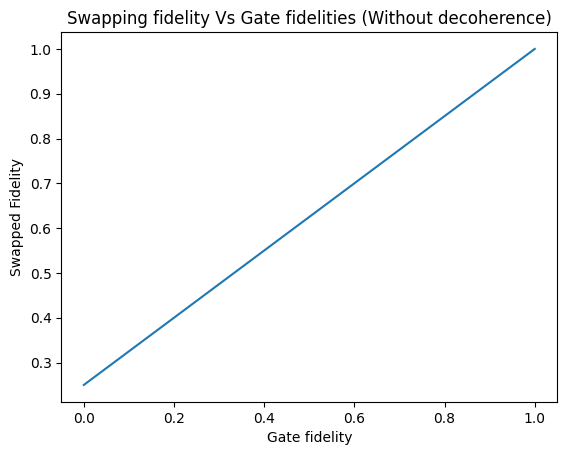

In [ ]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

from SeQUeNCe.src.topology.router_net_topo import RouterNetTopo
from SeQUeNCe.src.app.request_app import RequestApp
import SeQUeNCe.src.utils.log as log


CONFIG_FILE = "config_files/swap.json"

# meta params
NO_TRIALS = 1
OUTPUT_FILE = "results/variable_decoherence.csv"
LOGGING = False
LOG_OUTPUT = "results/var_decoherence_log.csv"
MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app", "optical_channel", "resource_manager"]

# simulation params
PREP_TIME = int(1e12)  # 1 second
COLLECT_TIME = int(1e11)  # 3.1, 10 seconds

# qc params
QC_FREQ = 1e11
total_distance = 20  # (unit: km)
gate_fidelities = np.linspace(1,0,int(1/0.05)+1)
print("gate_fidelities:", gate_fidelities)


# application params
APP_NODE_NAME = "left"
OTHER_NODE_NAME = "right"
num_memo = 1

# storing data
data_dict = {"Distance": [],
             "Average Throughput": [],
             "Std. Throughput": [],
             "Average_TTT": [],
             "probs":[]}


tick = time.time()
gate_swapped_fidelities = []

for i, gate_fidelity in enumerate(gate_fidelities):
    print(f"Running {NO_TRIALS} trials for distance {gate_fidelity}km ({i + 1}/{len(gate_fidelities)})")
    data_dict["Distance"].append(gate_fidelity)
    throughputs = np.zeros(NO_TRIALS)
    time_to_thousand = np.zeros(NO_TRIALS)
    probs = np.zeros(NO_TRIALS)
    temp_fidelities = []

    for trial_no in range(NO_TRIALS):
        # establish network
        net_topo = RouterNetTopo(CONFIG_FILE)

        # timeline setup
        tl = net_topo.get_timeline()
        tl.stop_time = PREP_TIME + COLLECT_TIME

        # Logging stuff
        if LOGGING:
            # set log
            if i == 3:
                log.set_logger(__name__, tl, LOG_OUTPUT)
                log.set_logger_level('WARN')
                for module in MODULE_TO_LOG:
                    log.track_module(module)
            elif i == 4:
                for module in MODULE_TO_LOG:
                    log.remove_module(module)

        # network configuration
        routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
        bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

        for j, node in enumerate(routers + bsm_nodes):
            node.set_seed(j + (trial_no * 3))

        # set gate fidelities
        for router in routers:
            router.gate_fid = gate_fidelity
                
        # establish app on left node
        start_node = None
        for node in routers:
            if node.name == APP_NODE_NAME:
                start_node = node
                break
        if not start_node:
            raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
        end_node = None
        for node in routers:
            if node.name == OTHER_NODE_NAME:
                end_node = node
                break
        if not start_node:
            raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

        app_start = RequestApp(start_node)
        app_end = RequestApp(end_node)

        tl.init()
        app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1)
        tl.run()

        temp_fidelities.append(routers[0].new_fidelity)
    gate_swapped_fidelities.append(temp_fidelities)

    print("Finished trials.")

print(gate_swapped_fidelities)
plt.title("Swapping fidelity Vs Gate fidelities (Without decoherence)")
plt.xlabel("Gate fidelity")
plt.ylabel("Swapped Fidelity")
plt.plot(gate_fidelities, gate_swapped_fidelities)

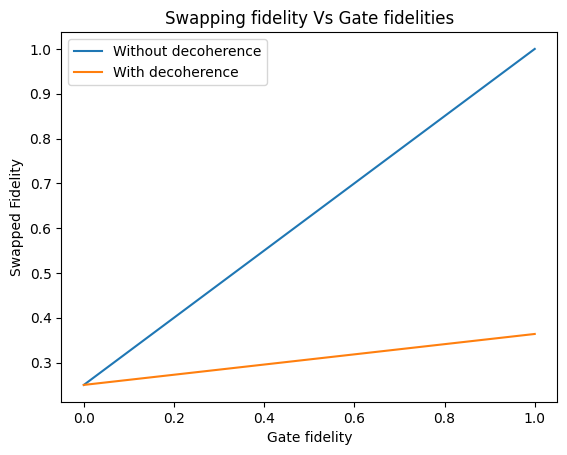

In [ ]:
plt.title("Swapping fidelity Vs Gate fidelities")
plt.xlabel("Gate fidelity")
plt.ylabel("Swapped Fidelity")
plt.plot(gate_fidelities, gate_swapped_fidelities, label="Without decoherence")
plt.plot(gate_fidelities, gate_swapped_fidelities_decoherence, label="With decoherence")
plt.legend()

Running 100 trials for distance 1.0km (1/40)
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelity
memo size: 1
adding fidelit

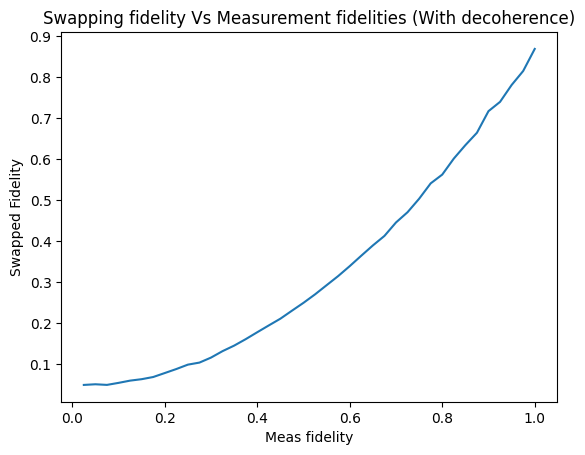

In [ ]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

from SeQUeNCe.src.topology.router_net_topo import RouterNetTopo
from SeQUeNCe.src.app.request_app import RequestApp
import SeQUeNCe.src.utils.log as log


CONFIG_FILE = "config_files/swap_decoherence.json"

# meta params
NO_TRIALS = 100
OUTPUT_FILE = "results/variable_decoherence.csv"
LOGGING = False
LOG_OUTPUT = "results/var_decoherence_log.csv"
MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app", "optical_channel", "resource_manager"]

# simulation params
PREP_TIME = int(1e12)  # 1 second
COLLECT_TIME = int(5e10)  # 3.1, 10 seconds

# qc params
QC_FREQ = 1e11
total_distance = 20  # (unit: km)
# distances = list(range(0,21))  # iterate through these (unit: km). distance of bsm from left. 
# meas_fidelities = np.linspace(0.1,1,20)
# meas_fidelities = np.linspace(0,1,int(1/0.05)+1)[1:]
meas_fidelities = np.linspace(1,0.025,int(0.975/0.025)+1)
coherence_times = [0.03]

# application params
APP_NODE_NAME = "left"
OTHER_NODE_NAME = "right"
num_memo = 1

# storing data
data_dict = {"Distance": [],
             "Average Throughput": [],
             "Std. Throughput": [],
             "Average_TTT": [],
             "probs":[]}


fidelity_by_coherence = []
for coherence_time in coherence_times:
    tick = time.time()
    meas_swapped_fidelities_decoherence = []
    for i, meas_fidelity in enumerate(meas_fidelities):
        print(f"Running {NO_TRIALS} trials for distance {meas_fidelity}km ({i + 1}/{len(meas_fidelities)})")
        data_dict["Distance"].append(meas_fidelity)
        throughputs = np.zeros(NO_TRIALS)
        time_to_thousand = np.zeros(NO_TRIALS)
        probs = np.zeros(NO_TRIALS)
        temp_fidelities = []

        for trial_no in range(NO_TRIALS):
            # establish network
            net_topo = RouterNetTopo(CONFIG_FILE)

            # timeline setup
            tl = net_topo.get_timeline()
            tl.stop_time = PREP_TIME + COLLECT_TIME

            # Logging stuff
            if LOGGING:
                # set log
                if i == 3:
                    log.set_logger(__name__, tl, LOG_OUTPUT)
                    log.set_logger_level('WARN')
                    for module in MODULE_TO_LOG:
                        log.track_module(module)
                elif i == 4:
                    for module in MODULE_TO_LOG:
                        log.remove_module(module)

            # network configuration
            routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
            bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

            for j, node in enumerate(routers + bsm_nodes):
                node.set_seed(j + (trial_no * 3))

            # set gate fidelities
            for router in routers:
                router.meas_fid = meas_fidelity

            # establish app on left node
            start_node = None
            for node in routers:
                for memory in node.memory_array.memories:
                    memory.coherence_time = coherence_time
                    memory.decoherence_rate = 1/memory.coherence_time 
                if node.name == APP_NODE_NAME:
                    start_node = node
                    break
            if not start_node:
                raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
            end_node = None
            for node in routers:
                if node.name == OTHER_NODE_NAME:
                    end_node = node
                    break
            if not start_node:
                raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

            app_start = RequestApp(start_node)
            app_end = RequestApp(end_node)

            # initialize and start app
            tl.init()
            app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1)
            tl.run()

            print("adding fidelity")

            temp_fidelities.append(routers[0].new_fidelity)
        meas_swapped_fidelities_decoherence.append(np.mean(temp_fidelities))
        print("Finished trials.")
    fidelity_by_coherence.append(meas_swapped_fidelities_decoherence)

print(meas_swapped_fidelities_decoherence)
# plt.plot()
# print(gate_swapped_fidelities_decoherence)
plt.title("Swapping fidelity Vs Measurement fidelities (With decoherence)")
plt.xlabel("Meas fidelity")
plt.ylabel("Swapped Fidelity")
plt.plot(meas_fidelities, meas_swapped_fidelities_decoherence)

In [ ]:
meas_fidelities

array([1.   , 0.975, 0.95 , 0.925, 0.9  , 0.875, 0.85 , 0.825, 0.8  ,
       0.775, 0.75 , 0.725, 0.7  , 0.675, 0.65 , 0.625, 0.6  , 0.575,
       0.55 , 0.525, 0.5  , 0.475, 0.45 , 0.425, 0.4  , 0.375, 0.35 ,
       0.325, 0.3  , 0.275, 0.25 , 0.225, 0.2  , 0.175, 0.15 , 0.125,
       0.1  , 0.075, 0.05 , 0.025])

[0.8682520326475804,
 0.8144906302792252,
 0.7803614799633033,
 0.739322546343738,
 0.7167084398241629,
 0.6640629160442755,
 0.6339071850901076,
 0.6011995271978288,
 0.5622218212365023,
 0.5408714531831031,
 0.5033647296309179,
 0.47064024241462,
 0.44565947377977116,
 0.4128889929423242,
 0.3897095075379797,
 0.36478176414511304,
 0.33937757379249367,
 0.31516103317253785,
 0.2929282021346779,
 0.27061898625276365,
 0.24999999999999992,
 0.23080164509145262,
 0.21134682453983294,
 0.19498591646038427,
 0.17836691605832541,
 0.1614872646625334,
 0.1457432774130043,
 0.13234974054185009,
 0.11662130214344703,
 0.10443922689147529,
 0.09946092429566807,
 0.08875769035158232,
 0.07900227765895623,
 0.06932105606398525,
 0.06404478374905444,
 0.06052626694885031,
 0.0550427789990074,
 0.050146426270047145,
 0.05165846865617883,
 0.050074358308241085]

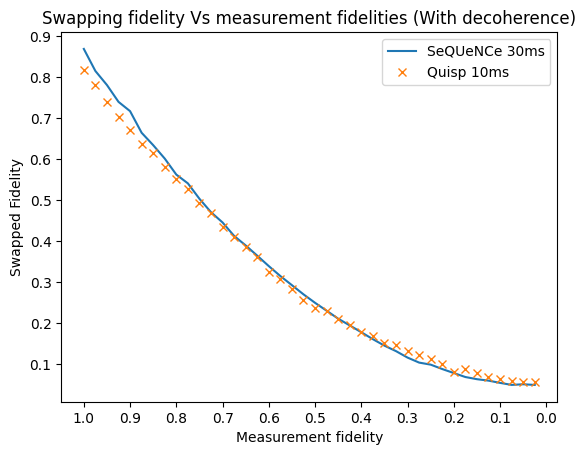

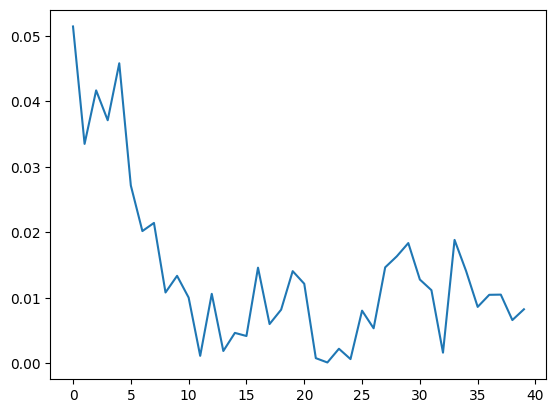

In [ ]:
# csvfile = open('plotting/quisp_10ms_error.csv','r') 
# df = pd.read_csv(csvfile)
# Quisp_fidelities = list(df["Quisp_10ms_meas"])



# plt.title("Swapping fidelity Vs Gate fidelities (With decoherence)")
# plt.xlabel("Gate fidelity")
# plt.ylabel("Swapped Fidelity")
# for i in range(len(fidelity_by_coherence)):
#     plt.plot(fidelity_by_coherence[i][::-1], label = f"SeQUeNCe {int(coherence_times[i]*1e3)}ms")
# plt.plot(Quisp_fidelities, 'x', label = "Quisp 10ms",)
# plt.legend()
# length = len(fidelity_by_coherence[0])
# plt.xticks(list(range(0,21,2)), [i/10 for i in list(range(10,-1, -1))])

csvfile = open('plotting/quisp_10ms_error.csv','r') 
df = pd.read_csv(csvfile)
Quisp_fidelities = list(df["Quisp_10ms_meas"])



plt.title("Swapping fidelity Vs measurement fidelities (With decoherence)")
plt.xlabel("Measurement fidelity")
plt.ylabel("Swapped Fidelity")
for i in range(len(fidelity_by_coherence)):
    plt.plot(fidelity_by_coherence[i], label = f"SeQUeNCe {int(coherence_times[i]*1e3)}ms")
plt.plot(Quisp_fidelities, 'x', label = "Quisp 10ms",)
plt.legend()
length = len(fidelity_by_coherence[0])
plt.xticks(list(range(0,41,4)), [i/10 for i in list(range(10,-1, -1))])

plt.figure()
plt.plot(np.abs(fidelity_by_coherence[0]-np.array(df["Quisp_10ms_meas"])))

fidelity_by_coherence[i]

In [ ]:
DF = pd.DataFrame(fidelity_by_coherence[i]) 
  
# save the dataframe as a csv file 
DF.to_csv("SeQUeNCe_meas_swap.csv")